In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from mplsoccer import Pitch, VerticalPitch
from scipy.ndimage import gaussian_filter

### 1. Areas of control 

Idea 
1. Create a master dictionary where key is the team and the value is a np array
2. For each team, get a list of MatchIds involved
3. For each match id
    - Bin the touches 6 equal bins of X and 5 Juego Y then get the 
    - Count the number of touches in each x,y (similar to the xt method) for the team and all the opponents 
    - For i,j in zip(x_bins,y_bins):
        - set 1 if team -1 if opponent bigger than threshold else 0 if contested 



In [2]:
query = f'''
WITH Touches as (
SELECT
  TeamId,
  MatchId,
  teams.team as team,
  PlayerId,
  players.player as Player,
  X,
  Y,
  Type,
  OutcomeType,
  SatisfiedEventsTypes,
  PassEndX,
  PassEndY,
  Zone,
  Length,
  Angle,
FROM
  `soccer-analytics-344915.Event_Data.World_Cup_2022` as wc
LEFT JOIN 
  `soccer-analytics-344915.Lookup_Tables.Players` as players ON wc.PlayerId = players.id
LEFT JOIN 
  `soccer-analytics-344915.Lookup_Tables.Teams` as teams ON wc.TeamId = teams.id
WHERE
isTouch = True)

SELECT * from Touches 
WHERE (
  SELECT count(1)
  FROM UNNEST(SatisfiedEventsTypes) as events
  WHERE events in (5,6,21,22,31,32,33,34,42,44,45,48,50,51,132,133,134,135,136,212)
) <= 0


'''
all_touches = pd.read_gbq(query, project_id='soccer-analytics-344915')

In [3]:
teams = all_touches['team'].unique()
touch_dict = {}
x_bins = [0,17,33.5,50,66.5,83,100] #vertical bins
y_bins = [0,21.1,36.8,63.2,78.9,100] #horizontal bins
THESHOLD = 0.56
for team in teams:
    matches = all_touches[all_touches['team'] == team]['MatchId'].unique()
    team_touch = all_touches[all_touches['team'] == team].copy()
    opponent = all_touches[(all_touches['MatchId'].isin(matches)) & (all_touches['team'] != team)].copy()
    opponent['X'] = (100 - opponent['X'])
    team_touch['x_bin'] = pd.cut(team_touch['X'], bins=x_bins, labels=False)
    team_touch['y_bin'] = pd.cut(team_touch['Y'], bins=y_bins, labels=False)
    opponent['x_bin'] = pd.cut(opponent['X'], bins=x_bins, labels=False)
    opponent['y_bin'] = pd.cut(opponent['Y'], bins=y_bins, labels=False)
    array = np.empty((len(x_bins) - 1,len(y_bins) - 1),dtype='int')
    grouped = team_touch.groupby(['x_bin','y_bin']).size().to_frame().reset_index()
    grouped_opponent = opponent.groupby(['x_bin','y_bin']).size().to_frame().reset_index()
    for i in range(0,len(x_bins) - 1):
        for j in range(0, len(y_bins) - 1):
            team_touches = int(grouped[grouped['x_bin'] == i][grouped['y_bin'] == j][0].values) 
            opponent_touches = int(grouped_opponent[grouped_opponent['x_bin'] == i][grouped_opponent['y_bin'] == j][0].values)
            total = team_touches + opponent_touches
            team_pct = team_touches/total
            opp_pct = opponent_touches/total
            if team_pct >= THESHOLD:
                array[i,j] = 1
            elif opp_pct >= THESHOLD:
                array[i,j] = -1
            else:
                array[i,j] = 0
    touch_dict[team] = array.transpose()
    

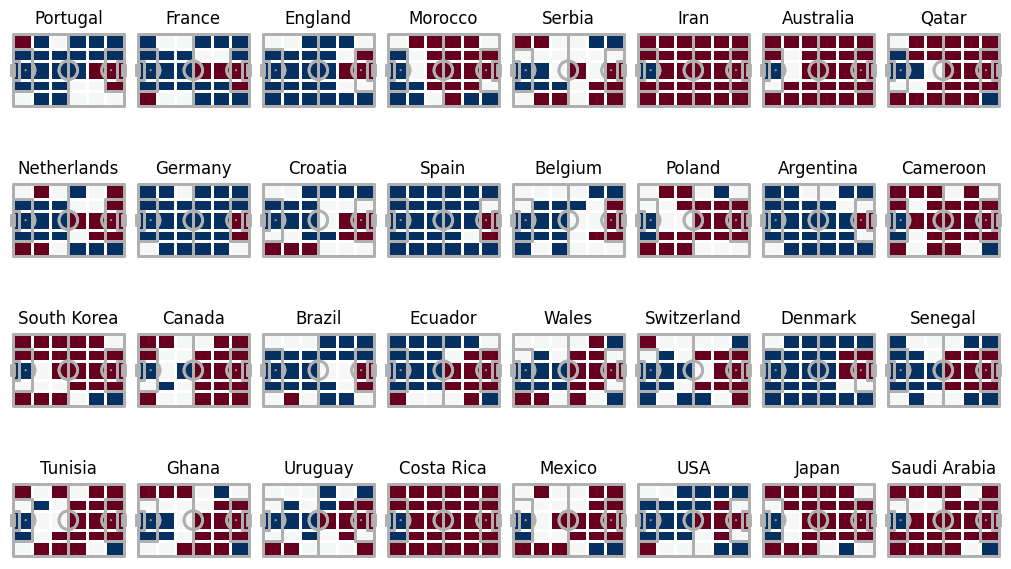

In [11]:
plt.rcParams['figure.figsize'] = [10,6]
pitch = Pitch(pitch_type='opta',line_zorder=2)
fig, axs = pitch.draw(nrows=4, ncols=8, tight_layout=False, constrained_layout=True)
for team, ax in zip(teams, axs.flatten()):
    pitch.draw(ax=ax)
    ax.pcolormesh(x_bins,y_bins,touch_dict[team], cmap='RdBu', vmin=-1, vmax=1,edgecolor ='white')
    ax.set_title(team)
    #ax.axis('off')

### 2. Shot Map 
idea 
1. Find the top 8 xg shotters (this one just hard code from fbref xg data)
2. Hex bin and median distance 

### 3. Goal Kick Sonars 
KDE Plot of End Locations?

### 4. Scatter Plot Ideas 
- Dribble attempted vs won %
- Shot Prevented vs xg 
- Goals Prevented / xGot (bar)
- PPDA vs High Turnovers (?)
